Extract feature from TVDN with the following modifications 

> TVDN fmri 可不可以这么做，用whole brain data get A， eigen decompose A， get the most important the U in each of the seven networks. For example, if the third and fourth and fifth U corresponding to the DMN, we retain the third U. We do this for each network, then we will have 7 U. Then do the change point detection.


In [1]:
import sys
sys.path.append("../mypkg")

In [2]:
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT
from utils.misc import load_pkl, save_pkl
from utils.colors import qual_cmap
from pyTVDN import TVDNDetect

In [3]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [4]:
import numpy as np
import scipy
from scipy.io import loadmat
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
import bct # the pkg to get graph features
from joblib import Parallel, delayed
from easydict import EasyDict as edict
import pandas as pd

plt.style.use(FIG_ROOT/'base.mplstyle')

# Fns and params

## Some fns

In [5]:
from prettytable import PrettyTable as PT
from scipy.stats import f_oneway, ttest_ind 

def _get_test_tb(res_df):
    tb = PT()
    tb.field_names = ["Test", "Pval", "Effect size"]
    
    HC = res_df["metric"][res_df["diagnosis"]==6]
    
    def indicator(pval):
        if pval < 0.05:
            return "*"
        else:
            return ""
    # list all disease
    for diag_ix in range(1, 6):
        DS = res_df["metric"][res_df["diagnosis"]==diag_ix]
        ttest_res = ttest_ind(DS, HC)
        effect_size = (np.mean(DS)-np.mean(HC))/np.std(np.concatenate([DS, HC]), ddof=2)
        tb.add_row([f"{indicator(ttest_res.pvalue)}{diag_lab_mapping[diag_ix]} vs HC", 
                      f"{ttest_res.pvalue:>6.3f}", 
                      f"{effect_size:>6.3f}"])
    
    # pool 5 diseases together
    DS = res_df["metric"][res_df["diagnosis"]!=6]
    ttest_res = ttest_ind(DS, HC)
    effect_size = (np.mean(DS)-np.mean(HC))/np.std(np.concatenate([DS, HC]), ddof=2)
    tb.add_row([f"{indicator(ttest_res.pvalue)}Dementia vs HC", 
                f"{ttest_res.pvalue:>6.3f}", 
                f"{effect_size:>6.3f}"])
    
    # anova
    metric_grp = [res_df["metric"][res_df["diagnosis"]==grp_ix] for grp_ix in range(1, 7)]
    anova_res = f_oneway(*metric_grp)
    tb.add_row([f"{indicator(anova_res.pvalue)}ANOVA", 
                f"{anova_res.pvalue:>6.3f}", 
                f""])
    tb.align["Test"] = "r"
    tb.align["Pval"] = "c"
    tb.align["Effect size"] = "c"
    return tb

In [6]:
def _preprocess_ts(ts):
    """preprocessing, 
        1. detrend
        2. resample (len of seq has 235 or 555, I make it consistent to 235)
    """
    ts = signal.detrend(ts);
    if ts.shape[-1] > 235:
        ts = signal.resample(ts, num=235, axis=-1)
    return ts
    
    
def _load_data(n):
    """Sub idx is from 1, n: the sub idx
    """
    return mat_data['ts_321_273'][np.where(mat_data['subj_321_ts'][:, 0] == n)[0], :].transpose()

## Load data and params

In [23]:
# load data
mat_data = loadmat(DATA_ROOT/"ad_ftd_hc_fmri_data.mat");


yeo_7nets_dict = pd.read_csv(DATA_ROOT/"yeo_7nets_dict.txt");
yeo_7nets_dict = {yeo_7nets_dict["lab"][ix]:"_".join(yeo_7nets_dict["name"][ix].strip().split(" "))
                  for ix in range(7)}
labs = pd.read_csv(DATA_ROOT/"BN246_RegionList.csv");
yeo_7nets_lab = np.array(labs["Yeo_7network"][:246]);

num_rois = 246 # the BNA has 246 regions
num_sps = 321
ac_time = 485

485

In [8]:
diag_labs = mat_data["dx_321"].reshape(-1)
sex_labs = mat_data["sex_321"].reshape(-1)
mmse_scores = mat_data["mmse_321"].reshape(-1)
diag_lab_mapping = {
 1: "AD",
 2: "bvFTD",
 3: "CBS", 
 4: "nfvPPA", 
 5: "svPPA", 
 6: "HC"
}

{1: 'AD', 2: 'bvFTD', 3: 'CBS', 4: 'nfvPPA', 5: 'svPPA', 6: 'HC'}

# Run TVDN

In [9]:
tvdn_paras = edict()
# these two are most influential
tvdn_paras.fct = 0.1
tvdn_paras.lamb = 5e-5
# r is moderately influential
tvdn_paras.r = 8
# not very important
tvdn_paras.Lmin = 5
tvdn_paras.MaxM = 20

tvdn_paras.kappas = np.linspace(1, 2, 1000)
#tvdn_paras.kappas = np.linspace(1, 2, 100)


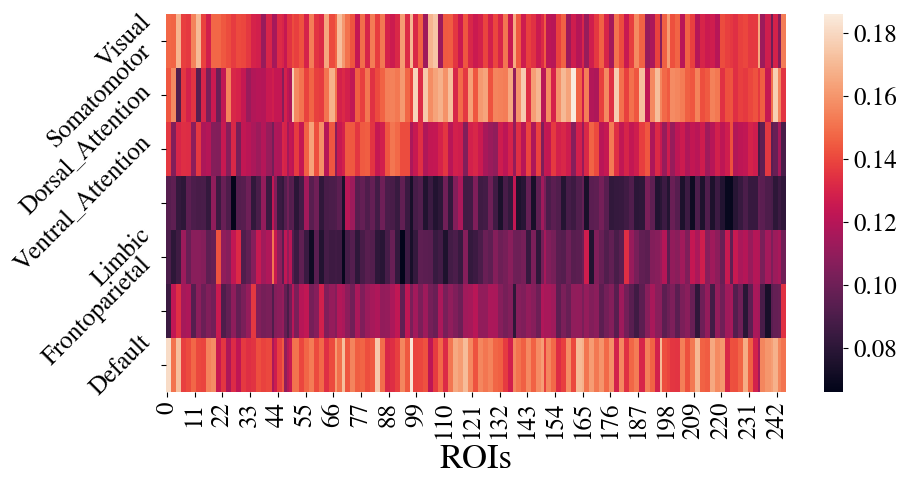

In [57]:
# Let us check whether U can correspond to 7 nets or not
sub_ix = 2
ts = _load_data(sub_ix)[:num_rois]
ts = _preprocess_ts(ts)
det = TVDNDetect(Ymat=ts,
                     showProgress=False,
                     saveDir=None,
                     fName=f"test",
                     dataType="fMRI", 
                     MaxM=tvdn_paras.MaxM, 
                     Lmin=tvdn_paras.Lmin, 
                     fct=tvdn_paras.fct, 
                     lamb=tvdn_paras.lamb, 
                     r=tvdn_paras.r); 

det.GetAmat()

eigVals, eigVecs = np.linalg.eig(det.Amat)
sidx = np.argsort(-np.abs(eigVals))
eigVals = eigVals[sidx]
eigVecs = eigVecs[:, sidx];

absUs = np.abs(eigVecs); # each col is a absU
absUs_norm = absUs.sum(axis=0);

all_ws = []
for net_ix in range(1, 8):
    all_ws.append(absUs[yeo_7nets_lab==net_ix].sum(axis=0)/absUs_norm)
all_ws = np.array(all_ws);

sns.heatmap(all_ws)
plt.yticks(np.arange(7)+0.5, [yeo_7nets_dict[net_ix] for net_ix in range(1, 8)], rotation=45);
plt.xlabel("ROIs");

## Get results


In [11]:
def _run_fn(sub_ix):
    ts = _load_data(sub_ix)[:num_rois]
    ts = _preprocess_ts(ts)
    det = TVDNDetect(Ymat=ts,
                     showProgress=False,
                     saveDir=RES_ROOT/"tvdn_res",
                     fName=f"sub_{sub_ix}",
                     dataType="fMRI", 
                     MaxM=tvdn_paras.MaxM, 
                     Lmin=tvdn_paras.Lmin, 
                     fct=tvdn_paras.fct, 
                     lamb=tvdn_paras.lamb, 
                     r=tvdn_paras.r); 
    #det.Screening(wh=5)
    det()
    det.TuningKappa(tvdn_paras.kappas)
    det.UpdateEcpts()
    return None


In [12]:
with Parallel(n_jobs=15) as parallel:
    res = parallel(delayed(_run_fn)(sub_ix) for sub_ix in tqdm(range(1, num_sps+1), total=num_sps))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [10:12<00:00,  1.91s/it]


Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_res/sub_12_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_res/sub_28_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_res/sub_39_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_res/sub_55_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_res/sub_71_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_res/sub_85_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_res/sub_100_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tv

Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_res/sub_4_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_res/sub_19_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_res/sub_29_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_res/sub_44_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_res/sub_60_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_res/sub_74_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_res/sub_90_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn

Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_res/sub_2_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_res/sub_21_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_res/sub_33_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_res/sub_52_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_res/sub_68_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_res/sub_83_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_res/sub_97_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn

Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_res/sub_3_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_res/sub_18_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_res/sub_38_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_res/sub_53_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_res/sub_66_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_res/sub_78_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_res/sub_91_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn

Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_res/sub_7_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_res/sub_22_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_res/sub_35_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_res/sub_50_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_res/sub_69_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_res/sub_80_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_res/sub_96_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn

## Kappa find

In [13]:
def _run_fn(sub_ix):
    ts = _load_data(sub_ix)[:num_rois]
    ts = _preprocess_ts(ts)
    det = TVDNDetect(Ymat=ts,
                     showProgress=False,
                     saveDir=RES_ROOT/"tvdn_res",
                     fName=f"sub_{sub_ix}",
                     dataType="fMRI", 
                     MaxM=tvdn_paras.MaxM, 
                     Lmin=tvdn_paras.Lmin, 
                     fct=tvdn_paras.fct, 
                     lamb=tvdn_paras.lamb, 
                     r=tvdn_paras.r); 
    #det.Screening(wh=5)
    det()
    det.TuningKappa(tvdn_paras.kappas)
    det.UpdateEcpts()
    return det


In [14]:
numchgss = []
for sub_ix in tqdm(np.where(diag_labs==6)[0]):
    det = _run_fn(sub_ix)
    numchgss.append(det.numchgs)
numchgss = np.array(numchgss);

  0%|                                                                                                                                                  | 0/100 [00:00<?, ?it/s]/data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/pyTVDN/TVDNclass.py:348: UserWarning: As loading the saved results, kappa will be ignored
  warnings.warn("As loading the saved results, kappa will be ignored", UserWarning)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.19it/s]


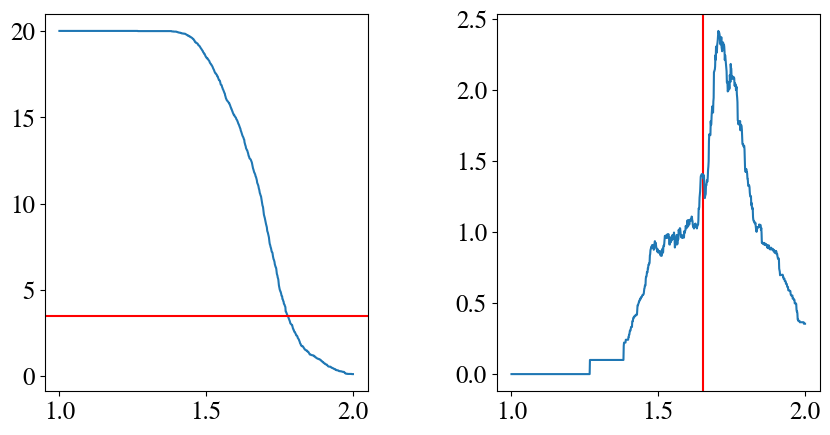

In [22]:
plt.subplot(121)
plt.plot(tvdn_paras.kappas, numchgss.mean(axis=0))
plt.axhline(y=3.5, color="red")
plt.subplot(122)
plt.axvline(x=1.653, color="red")
plt.plot(tvdn_paras.kappas, numchgss.std(axis=0))

In [24]:
# I choose 12 based on TVDN paper (in that paper, 8 pts for 310 second, we should have 12.5)
optkp = tvdn_paras.kappas[np.argmin(np.abs(numchgss.mean(axis=0)-12.5))]
print(f"The optimal kp is {optkp:.3f}.")

The optimal kp is 1.653.


## Get features

In [25]:
ecptss = []
for sub_ix in trange(1, num_sps+1):
    det = _run_fn(sub_ix)
    det.UpdateEcpts(det.numchgs[tvdn_paras.kappas==optkp][0])
    ecptss.append(det.ecpts)
save_pkl(RES_ROOT/f"tvdn_ecptss_kp{optkp*1000:.0f}.pkl", ecptss)

  0%|                                                                                                                                                  | 0/321 [00:00<?, ?it/s]/data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/pyTVDN/TVDNclass.py:348: UserWarning: As loading the saved results, kappa will be ignored
  warnings.warn("As loading the saved results, kappa will be ignored", UserWarning)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [05:35<00:00,  1.05s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_ecptss_kp1653.pkl


# Analyze

In [28]:
ecptss = load_pkl(RES_ROOT/f"tvdn_ecptss_kp1653.pkl")
ncpts = np.array([len(ecpts) for ecpts in ecptss]);

Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_ecptss_kp1653.pkl


In [29]:
res_df = pd.DataFrame({
    "metric": ncpts, 
    "sex": sex_labs, 
    "diagnosis": diag_labs
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
_get_test_tb(res_df)

Test,Pval,Effect size
AD vs HC,0.622,0.073
bvFTD vs HC,0.832,-0.039
CBS vs HC,0.803,-0.054
nfvPPA vs HC,0.199,0.254
svPPA vs HC,0.232,0.230
Dementia vs HC,0.448,0.092
ANOVA,0.614,


In [30]:
res_df.groupby("diagnosis1")["metric"].describe()

,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,12.621951,1.357560,9.0,12.00,13.0,13.75,16.0
CBS,27.0,12.444444,1.310705,9.0,12.00,13.0,13.00,15.0
HC,100.0,12.520000,1.410495,8.0,12.00,13.0,14.00,15.0
bvFTD,41.0,12.463415,1.501625,7.0,12.00,13.0,13.00,15.0
nfvPPA,34.0,12.882353,1.430505,7.0,12.25,13.0,14.00,15.0
svPPA,37.0,12.837838,1.280484,10.0,12.00,13.0,14.00,15.0
